In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, MolSurf, Fragments
from rdkit.Chem.EState import EState_VSA
from rdkit.Chem.GraphDescriptors import (
    BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3
)
from rdkit.Chem.EState.EState_VSA import (EState_VSA1, EState_VSA10, EState_VSA11, EState_VSA2, EState_VSA3,
    EState_VSA4, EState_VSA5, EState_VSA6, EState_VSA7, EState_VSA8, EState_VSA9, VSA_EState1, VSA_EState10,
    VSA_EState2, VSA_EState3, VSA_EState4, VSA_EState5, VSA_EState6, VSA_EState7, VSA_EState8, VSA_EState9
)
from rdkit.Chem.Descriptors import (ExactMolWt, MolWt, HeavyAtomMolWt, MaxAbsPartialCharge, MinPartialCharge,
    MaxPartialCharge, MinAbsPartialCharge, NumRadicalElectrons, NumValenceElectrons
)
from rdkit.Chem.EState.EState import MaxAbsEStateIndex, MaxEStateIndex, MinAbsEStateIndex, MinEStateIndex
from rdkit.Chem.Lipinski import (
    FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles, NumAliphaticHeterocycles, NumAliphaticRings,
    NumAromaticCarbocycles, NumAromaticHeterocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, RingCount,
    NumRotatableBonds, NumSaturatedCarbocycles, NumSaturatedHeterocycles, NumSaturatedRings
)
from rdkit.Chem.Crippen import MolLogP, MolMR
from rdkit.Chem.MolSurf import (
    LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14, PEOE_VSA2, PEOE_VSA3, PEOE_VSA4, PEOE_VSA5,
    PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9, SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6, SMR_VSA7,
    SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12, SlogP_VSA2, SlogP_VSA3, SlogP_VSA4, SlogP_VSA5,
    SlogP_VSA6, SlogP_VSA7, SlogP_VSA8, SlogP_VSA9, TPSA
)
from rdkit.Chem.Fragments import (
    fr_Al_COO, fr_Al_OH, fr_Al_OH_noTert, fr_ArN, fr_Ar_COO, fr_Ar_N, fr_Ar_NH, fr_Ar_OH, fr_COO, fr_COO2, fr_C_O, fr_C_O_noCOO,
    fr_C_S, fr_HOCCN, fr_Imine, fr_NH0, fr_NH1, fr_NH2, fr_N_O, fr_Ndealkylation1, fr_Ndealkylation2, fr_Nhpyrrole, fr_SH,
    fr_aldehyde, fr_alkyl_carbamate, fr_alkyl_halide, fr_allylic_oxid, fr_amide, fr_amidine, fr_aniline, fr_aryl_methyl,
    fr_azide, fr_azo, fr_barbitur, fr_benzene, fr_benzodiazepine, fr_bicyclic, fr_diazo, fr_dihydropyridine, fr_epoxide,
    fr_ester, fr_ether, fr_furan, fr_guanido, fr_halogen, fr_hdrzine, fr_hdrzone, fr_imidazole, fr_imide, fr_isocyan,
    fr_isothiocyan, fr_ketone, fr_ketone_Topliss, fr_lactam, fr_lactone, fr_methoxy, fr_morpholine, fr_nitrile, fr_nitro,
    fr_nitro_arom, fr_nitro_arom_nonortho, fr_nitroso, fr_oxazole, fr_oxime, fr_para_hydroxylation, fr_phenol,
    fr_phenol_noOrthoHbond, fr_phos_acid, fr_phos_ester, fr_piperdine, fr_piperzine, fr_priamide, fr_prisulfonamd,
    fr_pyridine, fr_quatN, fr_sulfide, fr_sulfonamd, fr_sulfone, fr_term_acetylene, fr_tetrazole, fr_thiazole, fr_thiocyan,
    fr_thiophene, fr_unbrch_alkane, fr_urea
)


In [213]:
# config
z_threshold = 10
relation = 0.75
scaler = RobustScaler()

In [199]:
pd.set_option('display.max_columns', None)

In [200]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

In [201]:
duplicatedSmiles = train['SMILES'].duplicated(keep=False)
duplicates = train[duplicatedSmiles].sort_values(by='SMILES')
duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [202]:
# 중복 약의 경우 기준값에 따라 max와 median을 취함
def custom_duplication(group):
    max_val = group.max()
    min_val = group.min()
    med_val = group.median()
    
    return max_val if max_val - min_val > 10 else med_val

train["MLM"] = train.groupby(by=["SMILES"])["MLM"].transform(custom_duplication)
train["HLM"] = train.groupby(by=["SMILES"])["HLM"].transform(custom_duplication)

train = train.drop_duplicates().reset_index(drop=True)

In [203]:
def add_feature(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {
        'BalabanJ': BalabanJ(mol),
        'BertzCT': BertzCT(mol),
        'Chi0': Chi0(mol),
        'Chi0n': Chi0n(mol),
        'Chi0v': Chi0v(mol),
        'Chi1': Chi1(mol),
        'Chi1n': Chi1n(mol),
        'Chi1v': Chi1v(mol),
        'Chi2n': Chi2n(mol),
        'Chi2v': Chi2v(mol),
        'Chi3n': Chi3n(mol),
        'Chi3v': Chi3v(mol),
        'Chi4n': Chi4n(mol),
        'Chi4v': Chi4v(mol),
        'EState_VSA1': EState_VSA1(mol),
        'EState_VSA10': EState_VSA10(mol),
        'EState_VSA11': EState_VSA11(mol),
        'EState_VSA2': EState_VSA2(mol),
        'EState_VSA3': EState_VSA3(mol),
        'EState_VSA4': EState_VSA4(mol),
        'EState_VSA5': EState_VSA5(mol),
        'EState_VSA6': EState_VSA6(mol),
        'EState_VSA7': EState_VSA7(mol),
        'EState_VSA8': EState_VSA8(mol),
        'EState_VSA9': EState_VSA9(mol),
        'ExactMolWt': ExactMolWt(mol),
        'FractionCSP3': FractionCSP3(mol),
        'HallKierAlpha': HallKierAlpha(mol),
        'HeavyAtomCount': HeavyAtomCount(mol),
        'HeavyAtomMolWt': HeavyAtomMolWt(mol),
        'Ipc': Ipc(mol),
        'Kappa1': Kappa1(mol),
        'Kappa2': Kappa2(mol),
        'Kappa3': Kappa3(mol),
        'LabuteASA': LabuteASA(mol),
        'MaxAbsEStateIndex': MaxAbsEStateIndex(mol),
        'MaxAbsPartialCharge': MaxAbsPartialCharge(mol),
        'MaxEStateIndex': MaxEStateIndex(mol),
        'MaxPartialCharge': MaxPartialCharge(mol),
        'MinAbsEStateIndex': MinAbsEStateIndex(mol),
        'MinAbsPartialCharge': MinAbsPartialCharge(mol),
        'MinEStateIndex': MinEStateIndex(mol),
        'MinPartialCharge': MinPartialCharge(mol),
        'MolLogP': MolLogP(mol),
        'MolMR': MolMR(mol),
        'MolWt': MolWt(mol),
        'NHOHCount': NHOHCount(mol),
        'NOCount': NOCount(mol),
        'NumAliphaticCarbocycles': NumAliphaticCarbocycles(mol),
        'NumAliphaticHeterocycles': NumAliphaticHeterocycles(mol),
        'NumAliphaticRings': NumAliphaticRings(mol),
        'NumAromaticCarbocycles': NumAromaticCarbocycles(mol),
        'NumAromaticHeterocycles': NumAromaticHeterocycles(mol),
        'NumAromaticRings': NumAromaticRings(mol),
        'NumHAcceptors': NumHAcceptors(mol),
        'NumHDonors': NumHDonors(mol),
        'NumHeteroatoms': NumHeteroatoms(mol),
        'NumRadicalElectrons': NumRadicalElectrons(mol),
        'NumRotatableBonds': NumRotatableBonds(mol),
        'NumSaturatedCarbocycles': NumSaturatedCarbocycles(mol),
        'NumSaturatedHeterocycles': NumSaturatedHeterocycles(mol),
        'NumSaturatedRings': NumSaturatedRings(mol),
        'NumValenceElectrons': NumValenceElectrons(mol),
        'PEOE_VSA1': PEOE_VSA1(mol),
        'PEOE_VSA10': PEOE_VSA10(mol),
        'PEOE_VSA11': PEOE_VSA11(mol),
        'PEOE_VSA12': PEOE_VSA12(mol),
        'PEOE_VSA13': PEOE_VSA13(mol),
        'PEOE_VSA14': PEOE_VSA14(mol),
        'PEOE_VSA2': PEOE_VSA2(mol),
        'PEOE_VSA3': PEOE_VSA3(mol),
        'PEOE_VSA4': PEOE_VSA4(mol),
        'PEOE_VSA5': PEOE_VSA5(mol),
        'PEOE_VSA6': PEOE_VSA6(mol),
        'PEOE_VSA7': PEOE_VSA7(mol),
        'PEOE_VSA8': PEOE_VSA8(mol),
        'PEOE_VSA9': PEOE_VSA9(mol),
        'RingCount': RingCount(mol),
        'SMR_VSA1': SMR_VSA1(mol),
        'SMR_VSA10': SMR_VSA10(mol),
        'SMR_VSA2': SMR_VSA2(mol),
        'SMR_VSA3': SMR_VSA3(mol),
        'SMR_VSA4': SMR_VSA4(mol),
        'SMR_VSA5': SMR_VSA5(mol),
        'SMR_VSA6': SMR_VSA6(mol),
        'SMR_VSA7': SMR_VSA7(mol),
        'SMR_VSA8': SMR_VSA8(mol),
        'SMR_VSA9': SMR_VSA9(mol),
        'SlogP_VSA1': SlogP_VSA1(mol),
        'SlogP_VSA10': SlogP_VSA10(mol),
        'SlogP_VSA11': SlogP_VSA11(mol),
        'SlogP_VSA12': SlogP_VSA12(mol),
        'SlogP_VSA2': SlogP_VSA2(mol),
        'SlogP_VSA3': SlogP_VSA3(mol),
        'SlogP_VSA4': SlogP_VSA4(mol),
        'SlogP_VSA5': SlogP_VSA5(mol),
        'SlogP_VSA6': SlogP_VSA6(mol),
        'SlogP_VSA7': SlogP_VSA7(mol),
        'SlogP_VSA8': SlogP_VSA8(mol),
        'SlogP_VSA9': SlogP_VSA9(mol),
        'TPSA': TPSA(mol),
        'VSA_EState1': VSA_EState1(mol),
        'VSA_EState10': VSA_EState10(mol),
        'VSA_EState2': VSA_EState2(mol),
        'VSA_EState3': VSA_EState3(mol),
        'VSA_EState4': VSA_EState4(mol),
        'VSA_EState5': VSA_EState5(mol),
        'VSA_EState6': VSA_EState6(mol),
        'VSA_EState7': VSA_EState7(mol),
        'VSA_EState8': VSA_EState8(mol),
        'VSA_EState9': VSA_EState9(mol),
        'fr_Al_COO': fr_Al_COO(mol),
        'fr_Al_OH': fr_Al_OH(mol),
        'fr_Al_OH_noTert': fr_Al_OH_noTert(mol),
        'fr_ArN': fr_ArN(mol),
        'fr_Ar_COO': fr_Ar_COO(mol),
        'fr_Ar_N': fr_Ar_N(mol),
        'fr_Ar_NH': fr_Ar_NH(mol),
        'fr_Ar_OH': fr_Ar_OH(mol),
        'fr_COO': fr_COO(mol),
        'fr_COO2': fr_COO2(mol),
        'fr_C_O': fr_C_O(mol),
        'fr_C_O_noCOO': fr_C_O_noCOO(mol),
        'fr_C_S': fr_C_S(mol),
        'fr_HOCCN': fr_HOCCN(mol),
        'fr_Imine': fr_Imine(mol),
        'fr_NH0': fr_NH0(mol),
        'fr_NH1': fr_NH1(mol),
        'fr_NH2': fr_NH2(mol),
        'fr_N_O': fr_N_O(mol),
        'fr_Ndealkylation1': fr_Ndealkylation1(mol),
        'fr_Ndealkylation2': fr_Ndealkylation2(mol),
        'fr_Nhpyrrole': fr_Nhpyrrole(mol),
        'fr_SH': fr_SH(mol),
        'fr_aldehyde': fr_aldehyde(mol),
        'fr_alkyl_carbamate': fr_alkyl_carbamate(mol),
        'fr_alkyl_halide': fr_alkyl_halide(mol),
        'fr_allylic_oxid': fr_allylic_oxid(mol),
        'fr_amide': fr_amide(mol),
        'fr_amidine': fr_amidine(mol),
        'fr_aniline': fr_aniline(mol),
        'fr_aryl_methyl': fr_aryl_methyl(mol),
        'fr_azide': fr_azide(mol),
        'fr_azo': fr_azo(mol),
        'fr_barbitur': fr_barbitur(mol),
        'fr_benzene': fr_benzene(mol),
        'fr_benzodiazepine': fr_benzodiazepine(mol),
        'fr_bicyclic': fr_bicyclic(mol),
        'fr_diazo': fr_diazo(mol),
        'fr_dihydropyridine': fr_dihydropyridine(mol),
        'fr_epoxide': fr_epoxide(mol),
        'fr_ester': fr_ester(mol),
        'fr_ether': fr_ether(mol),
        'fr_furan': fr_furan(mol),
        'fr_guanido': fr_guanido(mol),
        'fr_halogen': fr_halogen(mol),
        'fr_hdrzine': fr_hdrzine(mol),
        'fr_hdrzone': fr_hdrzone(mol),
        'fr_imidazole': fr_imidazole(mol),
        'fr_imide': fr_imide(mol),
        'fr_isocyan': fr_isocyan(mol),
        'fr_isothiocyan': fr_isothiocyan(mol),
        'fr_ketone': fr_ketone(mol),
        'fr_ketone_Topliss': fr_ketone_Topliss(mol),
        'fr_lactam': fr_lactam(mol),
        'fr_lactone': fr_lactone(mol),
        'fr_methoxy': fr_methoxy(mol),
        'fr_morpholine': fr_morpholine(mol),
        'fr_nitrile': fr_nitrile(mol),
        'fr_nitro': fr_nitro(mol),
        'fr_nitro_arom': fr_nitro_arom(mol),
        'fr_nitro_arom_nonortho': fr_nitro_arom_nonortho(mol),
        'fr_nitroso': fr_nitroso(mol),
        'fr_oxazole': fr_oxazole(mol),
        'fr_oxime': fr_oxime(mol),
        'fr_para_hydroxylation': fr_para_hydroxylation(mol),
        'fr_phenol': fr_phenol(mol),
        'fr_phenol_noOrthoHbond': fr_phenol_noOrthoHbond(mol),
        'fr_phos_acid': fr_phos_acid(mol),
        'fr_phos_ester': fr_phos_ester(mol),
        'fr_piperdine': fr_piperdine(mol),
        'fr_piperzine': fr_piperzine(mol),
        'fr_priamide': fr_priamide(mol),
        'fr_prisulfonamd': fr_prisulfonamd(mol),
        'fr_pyridine': fr_pyridine(mol),
        'fr_quatN': fr_quatN(mol),
        'fr_sulfide': fr_sulfide(mol),
        'fr_sulfonamd': fr_sulfonamd(mol),
        'fr_sulfone': fr_sulfone(mol),
        'fr_term_acetylene': fr_term_acetylene(mol),
        'fr_tetrazole': fr_tetrazole(mol),
        'fr_thiazole': fr_thiazole(mol),
        'fr_thiocyan': fr_thiocyan(mol),
        'fr_thiophene': fr_thiophene(mol),
        'fr_unbrch_alkane': fr_unbrch_alkane(mol),
        'fr_urea': fr_urea(mol)
        }

    return pd.Series(descriptors)

In [204]:
test

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.795,345.358,5,0,2,1.795,81.21
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.219,353.418,4,0,2,0.169,61.15
...,...,...,...,...,...,...,...,...,...
478,TEST_478,CCc1noc(CC)c1CC(=O)NCC1(CC)CCCCC1,4.207,306.443,2,1,7,4.207,55.13
479,TEST_479,CC(=O)N1CCC2(CC1)OC(=O)C(C)=C2C(=O)N1CCN(C)CC1,-0.608,335.398,5,0,1,-1.736,70.16
480,TEST_480,CC(C)NC(=O)CN1C(=O)c2ccccc2N2C(=O)c3ccccc3C12,1.792,349.383,3,1,3,1.792,69.72
481,TEST_481,Cn1cc(Br)c(=O)c(NC(=O)c2ccc(O)cc2F)c1,0.790,341.132,3,2,2,0.423,69.64


In [205]:
train = pd.concat([train, train['SMILES'].apply(add_feature)], axis=1)
test = pd.concat([test, test['SMILES'].apply(add_feature)], axis=1)

In [206]:
# 결측치 처리
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

In [207]:
# 이상치 처리
z_scores = stats.zscore(train.iloc[:, 4:])

outliers = train[(abs(z_scores) > z_threshold).any(axis=1)]
outliers

train.drop(outliers.index, inplace=True)

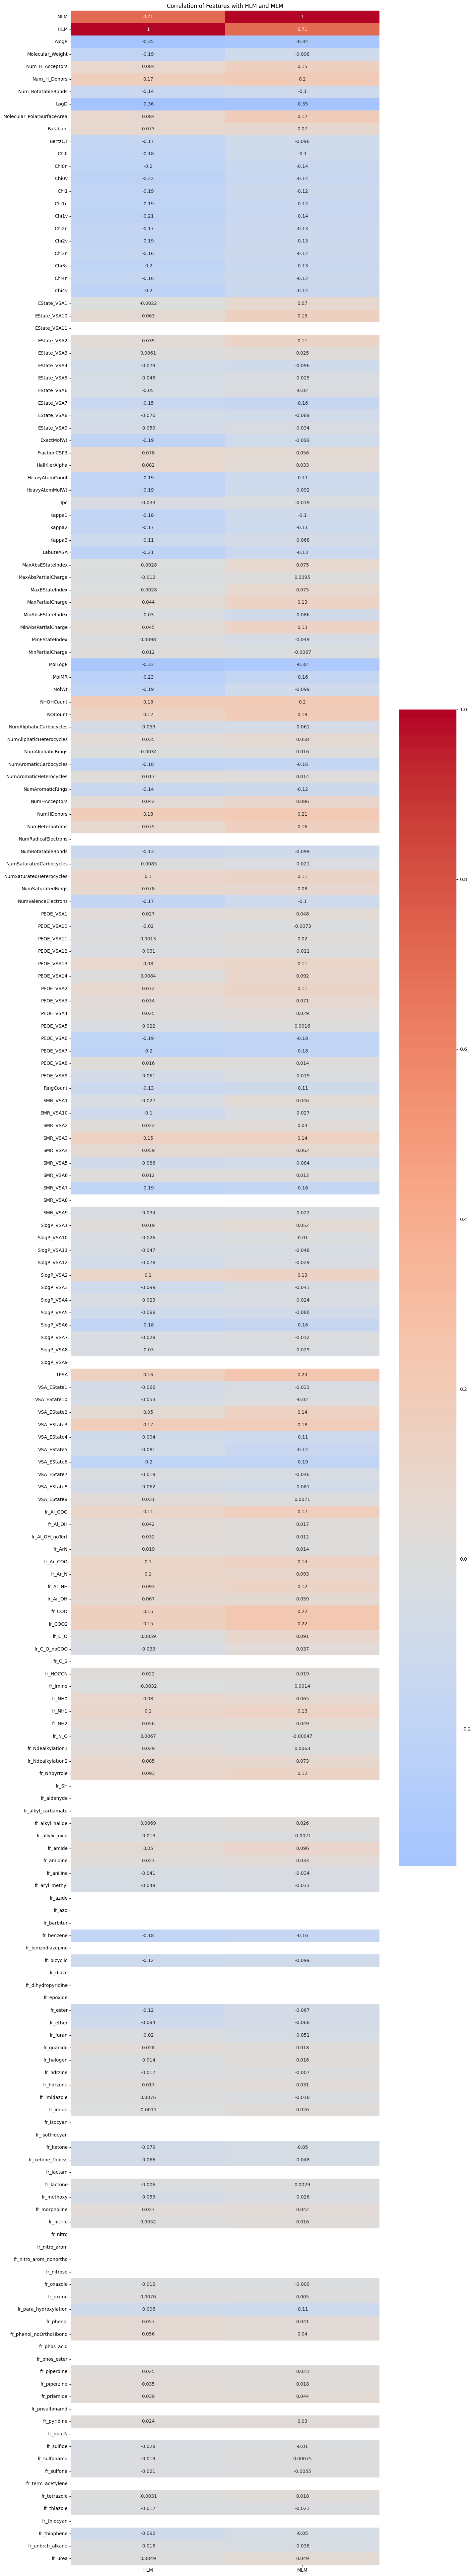

In [208]:
train_drop_odj = train.drop(['id', 'SMILES'], axis=1)

correlation_matrix = train_drop_odj.corr()

correlations = correlation_matrix.loc[['HLM', 'MLM'], :].T

plt.figure(figsize=(15, 100))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Features with HLM and MLM')
plt.show()

In [209]:
# # 기타 칼럼 값 분포 살펴보기
# sns.set_style("whitegrid")
# plt.figure(figsize=(18, 400))

# # Subplots for each feature
# features = train_hlm.columns.to_list()
# for i, feature in enumerate(features, 1):
#     plt.subplot(90, 4, i)
#     sns.histplot(train_hlm[feature], bins=50, kde=True)
#     plt.title(f"Distribution of {feature}")
#     plt.xlabel(feature)
#     plt.ylabel("Frequency")

# plt.tight_layout()
# plt.show()

In [210]:
# scaling
# train = scaler.fit_transform(train)
# test = scaler.transform(test)

In [214]:
# 둘다 relation 넘는 feature 모음 / 86 columns
filtered_features_00 = train_drop_odj.columns[(abs(correlation_matrix['HLM']) >= relation) & (abs(correlation_matrix['MLM']) >= relation)]

train_drop_feature_00 = train[['SMILES'] + list(filtered_features_00)]
train_drop_feature_00.to_csv('./Data/eda/h&m_and.csv', index=False)

test_drop_feature_00 = test[['SMILES'] + list(filtered_features_00)[2:]]
test_drop_feature_00.to_csv('./Data/eda/h&m_and_test.csv', index=False)

# 하나라도 relation 넘는 feature 모음 / 114 columns
filtered_features_01 = train_drop_odj.columns[(abs(correlation_matrix['HLM']) >= relation) | (abs(correlation_matrix['MLM']) >= relation)]

train_drop_feature_01 = train[['SMILES'] + list(filtered_features_01)]
train_drop_feature_01.to_csv('./Data/eda/h&m_or.csv', index=False)

test_drop_feature_01 = test[['SMILES'] + list(filtered_features_01)[2:]]
test_drop_feature_01.to_csv('./Data/eda/h&m_or_test.csv', index=False)

# mlm 만 구할때 / 98 columns
filtered_features_02 = train_drop_odj.columns[(abs(correlation_matrix['MLM']) >= relation)]

train_drop_feature_02 = train[list(filtered_features_02)].drop('HLM', axis=1)
train_drop_feature_02.to_csv('./Data/eda/mlm_or.csv', index=False)

test_drop_feature_02 = test[list(filtered_features_02)[2:]]
test_drop_feature_02.to_csv('./Data/eda/mlm_or_test.csv', index=False)

# hlm 만 구할때 / 99 columns
filtered_features_03 = train_drop_odj.columns[(abs(correlation_matrix['HLM']) >= relation)]

train_drop_feature_03 = train[list(filtered_features_03)]
train_drop_feature_03.to_csv('./Data/eda/hlm_or.csv', index=False)

test_drop_feature_03 = test[list(filtered_features_03)[2:]]
test_drop_feature_03.to_csv('./Data/eda/hlm_or_test.csv', index=False)


KeyError: "['HLM'] not found in axis"

In [212]:
len(filtered_features_00)

48